In [1]:
import os
from io import open
import glob
import unicodedata
import string

## Extraction and preprocessing

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
all_letters = string.ascii_letters + ".,;"

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [6]:
category_lines = {}
all_categories = []

In [7]:
for filename in findFiles('data/names/*.txt'):
    category = filename.replace('\\', '/').split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [8]:
n_letters = len(all_letters)
n_categories = len(all_categories)

## Pytorch

In [9]:
import torch

In [18]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J').size())
print(lineToTensor('Jones').size())

torch.Size([1, 55])
torch.Size([5, 1, 55])


In [11]:
import torch.nn as nn
from torch.autograd import Variable

In [121]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [122]:
# rnn = nn.GRU(10, 20, 2)
# input = Variable(torch.randn(5, 3, 10))
# h0 = Variable(torch.randn(2, 3, 20))
# output, hn = rnn(input, h0)

In [123]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))
output, next_hidden = rnn(input[0], hidden)

In [124]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))
output, next_hidden = rnn(input, hidden)

In [125]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [126]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([
                        all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

In [127]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(category, category_tensor.size(), line, line_tensor.size())

Scottish torch.Size([1]) Murphy torch.Size([6, 1, 55])
Czech torch.Size([1]) Hajicek torch.Size([7, 1, 55])
Czech torch.Size([1]) Kolman torch.Size([6, 1, 55])
Polish torch.Size([1]) Stawski torch.Size([7, 1, 55])
English torch.Size([1]) Overett torch.Size([7, 1, 55])
Dutch torch.Size([1]) Tunneson torch.Size([8, 1, 55])
French torch.Size([1]) Paris torch.Size([5, 1, 55])
Irish torch.Size([1]) Gorman torch.Size([6, 1, 55])
Scottish torch.Size([1]) Anderson torch.Size([8, 1, 55])
Portuguese torch.Size([1]) Paredes torch.Size([7, 1, 55])


In [128]:
criterion = nn.NLLLoss()

In [133]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [134]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [135]:
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [136]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.8398 Cremona / Irish ✗ (Italian)
10000 10% (0m 13s) 2.0487 Jelinek / Czech ✓
15000 15% (0m 23s) 0.8012 Quan / Chinese ✓
20000 20% (0m 29s) 1.1629 To / Vietnamese ✓
25000 25% (0m 37s) 3.0124 Sutherland / English ✗ (Scottish)
30000 30% (0m 43s) 1.4830 Neville / Irish ✓
35000 35% (0m 50s) 1.2434 Kunik / Czech ✓
40000 40% (0m 57s) 2.5812 Espinosa / Japanese ✗ (Spanish)
45000 45% (1m 4s) 1.2473 Thomson / Scottish ✓
50000 50% (1m 10s) 2.4282 Venne / Italian ✗ (Dutch)
55000 55% (1m 16s) 2.5108 Aquila / Portuguese ✗ (Italian)
60000 60% (1m 21s) 0.2923 Wojewodzki / Polish ✓
65000 65% (1m 27s) 0.5184 Otake / Japanese ✓
70000 70% (1m 32s) 0.5946 Delacruz / Spanish ✓
75000 75% (1m 37s) 2.7946 Pinter / German ✗ (Czech)
80000 80% (1m 41s) 3.0636 Mulder / Spanish ✗ (Dutch)
85000 85% (1m 47s) 1.0353 Desantigo / Spanish ✗ (Portuguese)
90000 90% (1m 54s) 0.5303 OKeefe / Irish ✓
95000 95% (1m 59s) 1.5070 Marino / Portuguese ✗ (Spanish)
100000 100% (2m 5s) 0.2695 Bishara / Arabic ✓


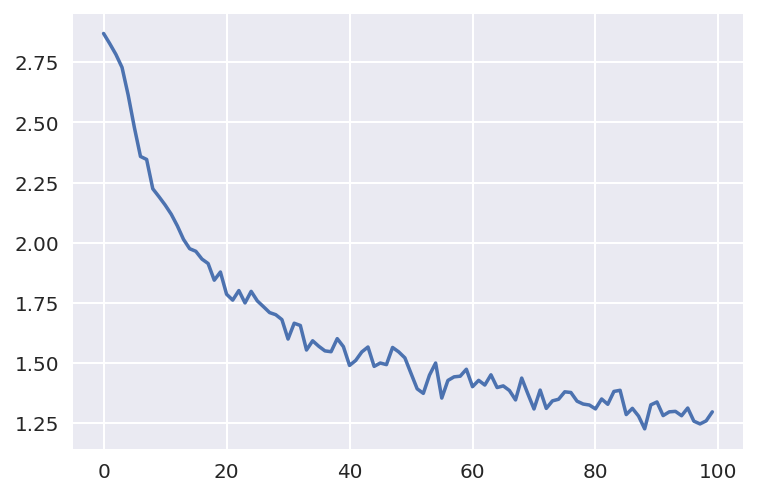

In [137]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

plt.figure()
plt.plot(all_losses)

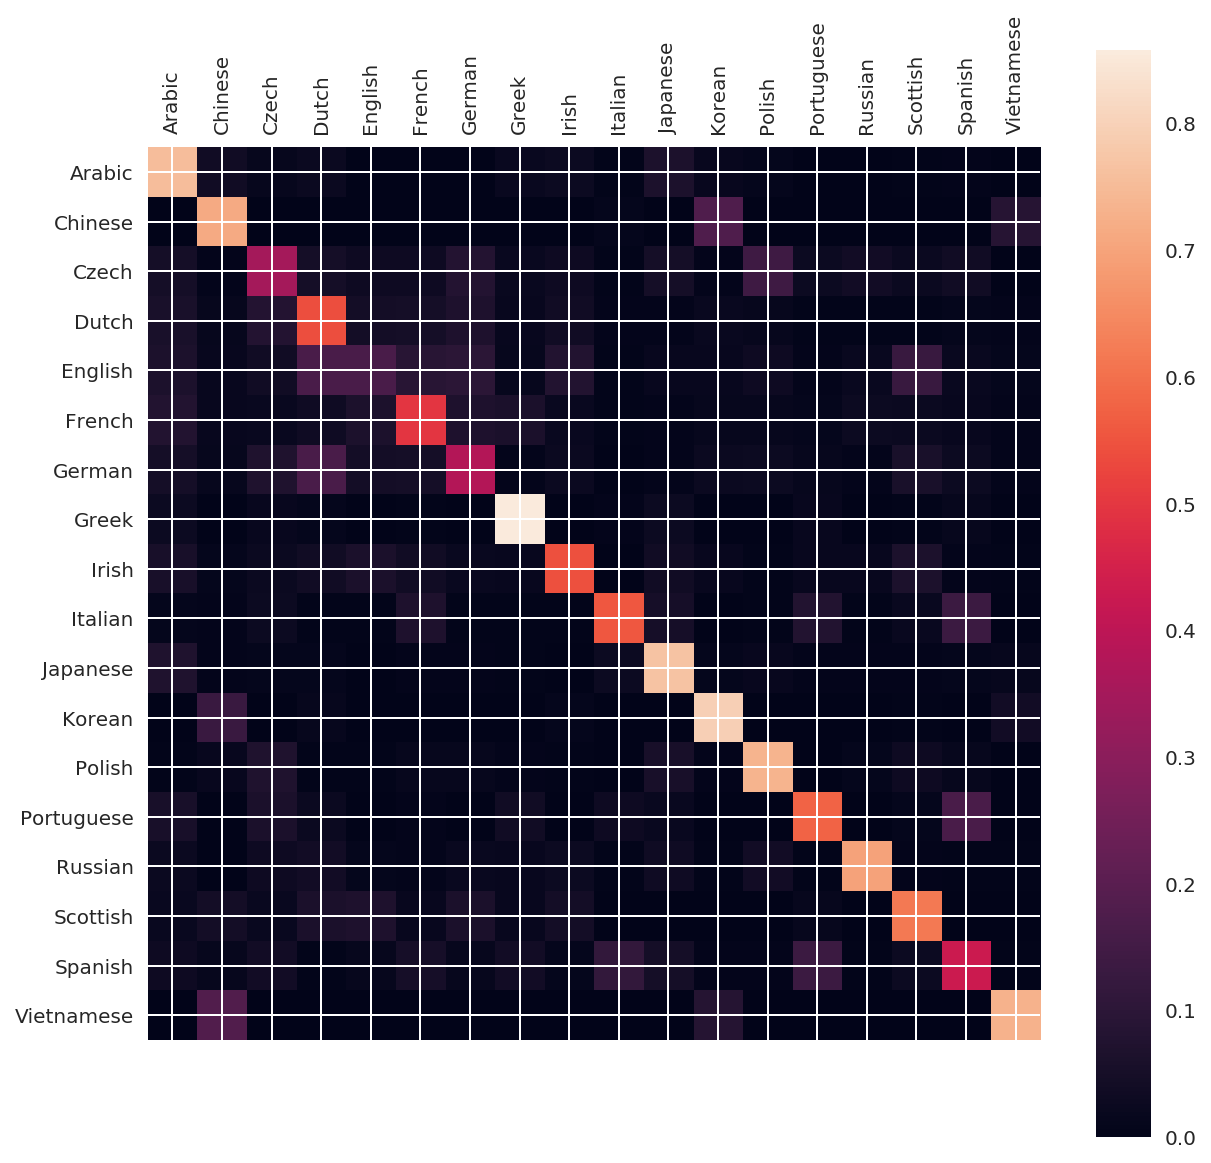

In [39]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [138]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Ferraro')
predict('Lorenzi')
predict('Patel')
predict('Aduviri')
predict('Choque')
predict('Tenorio')
predict('Vega')
predict('Beingolea')
predict('Han')
predict('Kamimura')
predict('Yong')
predict('Sandoval')
predict('ToTheFirstPage')


> Dovesky
(-0.41) Russian
(-1.60) Czech
(-3.11) Polish

> Jackson
(-0.18) Scottish
(-2.41) English
(-3.73) Greek

> Satoshi
(-0.83) Japanese
(-1.53) Italian
(-2.07) Polish

> Ferraro
(-0.30) Portuguese
(-2.22) Spanish
(-2.91) Italian

> Lorenzi
(-0.22) Italian
(-3.31) German
(-3.38) Russian

> Patel
(-1.50) Czech
(-1.93) Dutch
(-2.03) English

> Aduviri
(-0.14) Italian
(-3.02) French
(-4.21) Scottish

> Choque
(-0.87) Chinese
(-1.44) French
(-2.33) Arabic

> Tenorio
(-0.77) Portuguese
(-1.85) Spanish
(-1.89) Italian

> Vega
(-0.86) Spanish
(-2.04) Czech
(-2.32) Portuguese

> Beingolea
(-0.40) Spanish
(-2.42) Polish
(-2.47) Portuguese

> Han
(-0.38) Chinese
(-2.03) Korean
(-2.09) Vietnamese

> Kamimura
(-0.11) Japanese
(-3.74) Czech
(-3.84) Polish

> Yong
(-0.52) Korean
(-0.93) Chinese
(-4.93) Vietnamese

> Sandoval
(-1.20) Spanish
(-1.57) Czech
(-2.13) French

> ToTheFirstPage
(-1.22) Japanese
(-1.63) German
(-2.19) Czech
